In [1]:
import gc

import cufflinks as cf
import jieba
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline
cf.go_offline()
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth',100)
plt.style.use('seaborn')

第一次玩DF,发一个简单的疫情文本EDA试试。如果有帮助请点个赞。

## 读取数据

由于其他编码会出现少部分汉字乱码，比如“XX超话”、表情符号等。所以我手动用记事本转换成了 UTF-8 编码。

其中，超话以及其他特殊字符以“”表示，大部分表情符号被“??”代替。

In [2]:
train_labeled = pd.read_csv('./input/train_dataset/nCoV_100k_train_labled_utf8.csv', encoding='utf-8')
train_labeled.rename(columns = {"微博id": "Weibo_ID",
                                "微博发布时间": "Publish_Time", 
                                "发布人账号": "Account_ID",
                                "微博中文内容": "Chinese_Content",
                                "微博图片": "Pictures",
                                "微博视频": "Videos",
                                "情感倾向": "Labels"},  inplace=True)

train_labeled_copy = train_labeled.copy()

In [3]:
test = pd.read_csv('./input/test_dataset/nCov_10k_test_utf8.csv', encoding='utf-8')
test.rename(columns = {"微博id": "Weibo_ID",
                                "微博发布时间": "Publish_Time", 
                                "发布人账号": "Account_ID",
                                "微博中文内容": "Chinese_Content",
                                "微博图片": "Pictures",
                                "微博视频": "Videos"},  inplace=True)

test_copy = test.copy()

In [4]:
train_labeled.head(5)

,Weibo_ID,Publish_Time,Account_ID,Chinese_Content,Pictures,Videos,Labels
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早晨给孩子穿上红色的羽绒服羽绒裤，祈祷新的一年，孩子们身体康健。仍然会有一丝焦虑，焦虑我的孩子为什么会...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gahhwworn5j30m80fyq4n.jpg'],[],0
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1
2,4456054253264520,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年快乐，发烧好了就去浪吧，快快乐乐的度过这个美好假期，说不定以后就没有了嗷@邱晨虫仔2泉州·泉州理工学院?,"['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1gahft9xvnbj31o00u0jxt.jpg', 'https://ww1.sinaimg.cn...",[],1
3,4456061509126470,01月01日 23:08,芩鎟,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,['https://ww2.sinaimg.cn/orj360/005FL9LZgy1gahgp9gv71j31z41hce82.jpg'],[],1
4,4455979322528190,01月01日 17:42,changlwj,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。有坏的想法天神会记，叫“头上三尺有神灵”（明白）那么地府的官也会记，如果你坏得不是太厉害的意念，你只...,[],[],1


In [5]:
test.head(5)

,Weibo_ID,Publish_Time,Account_ID,Chinese_Content,Pictures,Videos
0,4456068992182160,01月01日 23:38,-精緻的豬豬女戰士-,#你好2020#新年第一天元气满满的早起出门买早饭结果高估了自己抗冻能力回家成功冻发烧（大概是想告诉我2020要量力而行）然鹅这并不影响后续计划一出门立马生龙活虎新年和新??更配哦??看了误杀...,"['https://ww2.sinaimg.cn/thumb150/745aa591ly1gahhjvh2k7j211u0u0th2.jpg', 'https://ww3.sinaimg.cn...",[]
1,4456424178427250,01月02日 23:09,liujunyi88,大宝又感冒鼻塞咳嗽了，还有发烧。队友加班几天不回。感觉自己的情绪在家已然是随时引爆的状态。情绪一上来，容易对孩子说出自己都想不到的话来……2020年，真的要学会控制情绪，管理好家人健康。这是今...,[],[]
2,4456797466940200,01月03日 23:53,ablsa,还要去输两天液，这天也太容易感冒发烧了，一定要多喝热水啊?,['https://ww3.sinaimg.cn/orj360/006fTidCly1gajt7wulilj31o01o07wh.jpg'],[]
3,4456791021108920,01月03日 23:27,喵吃鱼干Lynn,我太难了别人怎么发烧都没事就我一检查甲型流感?,[],[]
4,4457086404997440,01月04日 19:01,我的发小今年必脱单,果然是要病一场的喽回来第三天开始感冒今儿还发烧了喉咙眼睛都难受的一匹怎么样能不经意让我的毕设导师看到这条微博并给我放一天假呢?,[],[]


## 缺失值检查

检查一下训练集和测试集的缺失值，可以看出有些数据是缺失的。

In [6]:
train_labeled.isnull().any()

Weibo_ID           False
Publish_Time       False
Account_ID         False
Chinese_Content     True
Pictures           False
Videos             False
Labels              True
dtype: bool

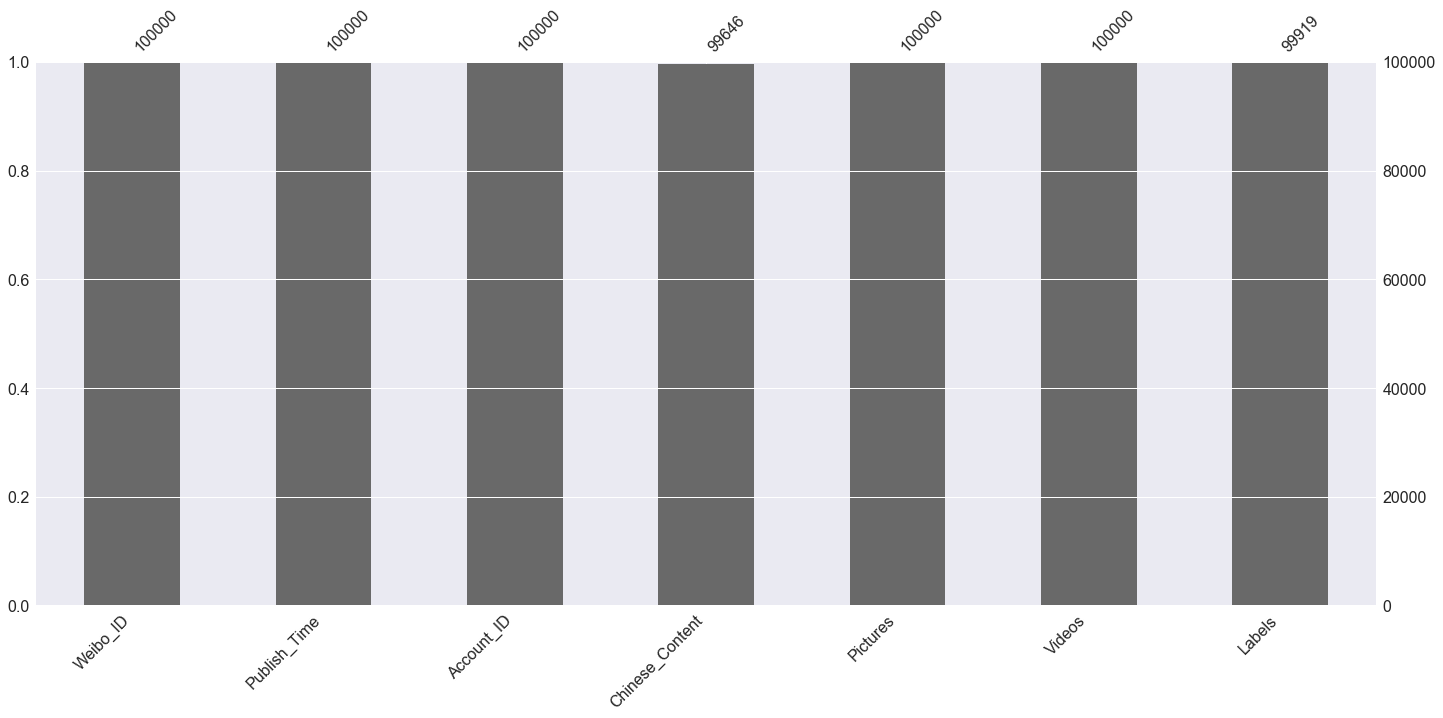

In [7]:
msno.bar(train_labeled)

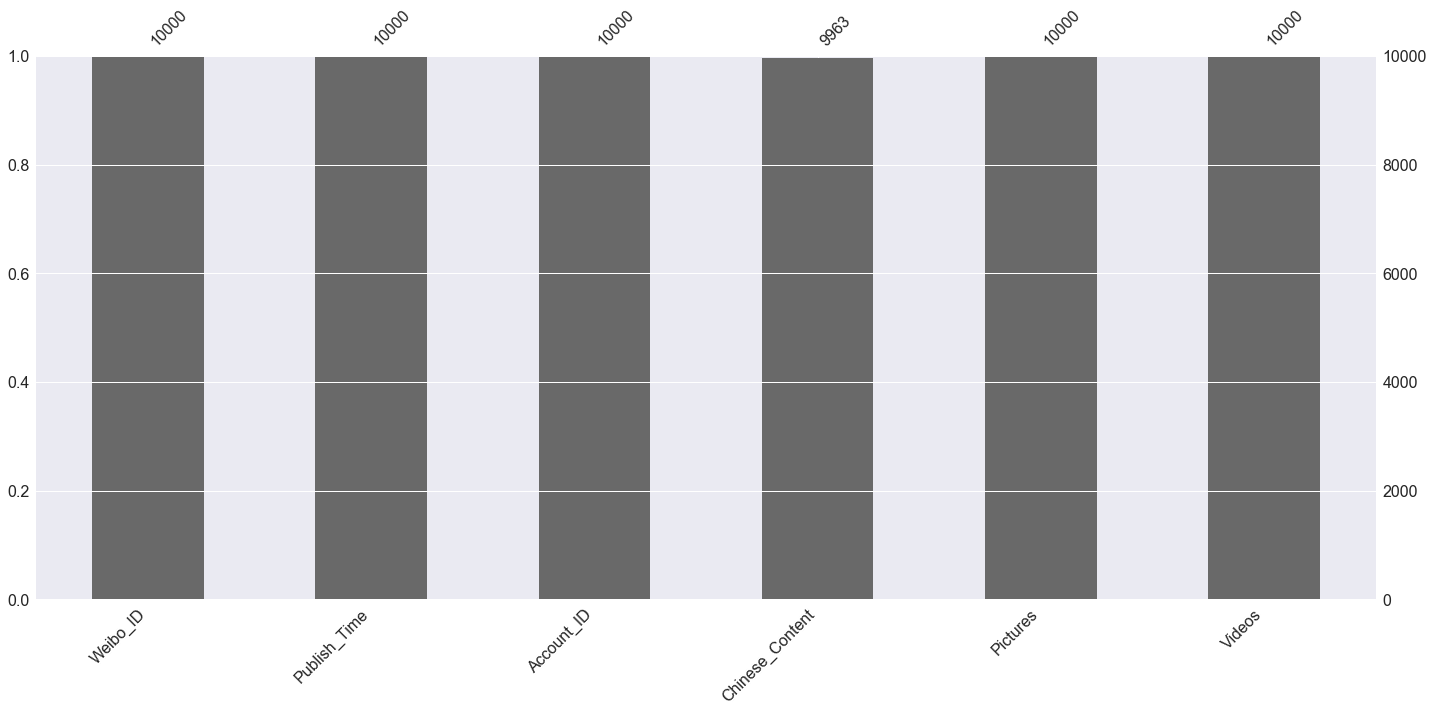

In [8]:
msno.bar(test)

有少量微博正文数据丢失，部分labels为空。

## 标签检查

标签统计如下：

In [9]:
train_labeled_copy.fillna({"Labels": "empty_label"}, inplace=True)

temp = train_labeled_copy["Labels"].value_counts()
temp_df = pd.DataFrame({'labels': temp.index,
                        'values': temp.values})

temp_df.iplot(kind='pie',labels='labels',values='values', title='Labels')

有6种噪音标签，每种各一个，此外还有一点点空标签，统计如下:

In [10]:
noise = train_labeled_copy[(train_labeled_copy["Labels"] != '0') & 
                           (train_labeled_copy["Labels"] != '1') & 
                           (train_labeled_copy["Labels"] != '-1')]

noise = noise["Labels"].value_counts()
noise_df = pd.DataFrame({'labels': noise.index,
                         'values': noise.values})

noise_df.iplot(kind='pie',labels='labels',values='values', title='奇怪标签统计')

对于非正常标签的处理，可以直接舍弃，也可以手工打上真正标签（如果不嫌累）。

这里我们直接舍弃就行。

## 发微博数量与时间关系

疫情和时间的分析用了包佬的代码。（你的代码很不错，不过下一秒就是我的了.jpg）

In [11]:
train_labeled_copy['time'] = pd.to_datetime('2020年' + train_labeled['Publish_Time'], format='%Y年%m月%d日 %H:%M', errors='ignore')
test_copy['time'] = pd.to_datetime('2020年' + train_labeled['Publish_Time'], format='%Y年%m月%d日 %H:%M', errors='ignore')

In [12]:
train_labeled_copy['month'] =  train_labeled_copy['time'].dt.month
train_labeled_copy['day'] =  train_labeled_copy['time'].dt.day
train_labeled_copy['dayfromzero']  = (train_labeled_copy['month'] - 1) * 31 +  train_labeled_copy['day']

test_copy['month'] =  test_copy['time'].dt.month
test_copy['day'] =  test_copy['time'].dt.day
test_copy['dayfromzero']  = (test_copy['month'] - 1) * 31 +  test_copy['day']

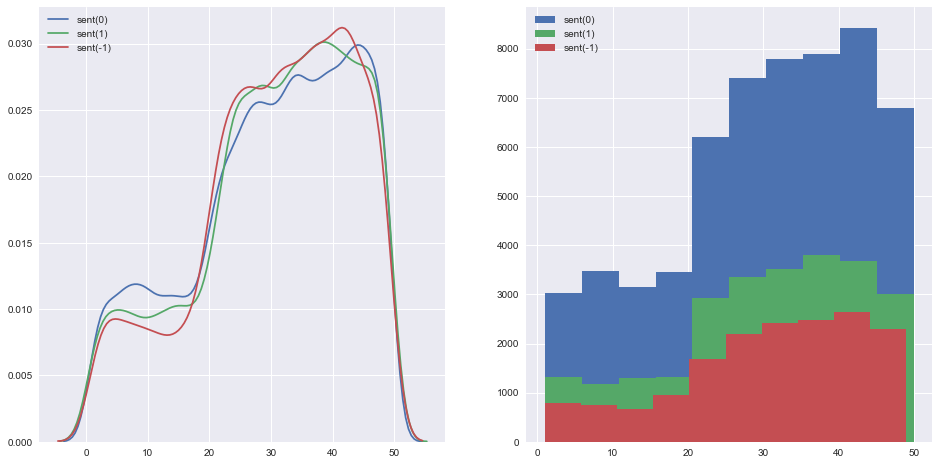

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '0', 'dayfromzero'], ax=ax[0], label='sent(0)')
sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '1', 'dayfromzero'], ax=ax[0], label='sent(1)')
sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '-1', 'dayfromzero'], ax=ax[0], label='sent(-1)')

train_labeled_copy.loc[train_labeled_copy['Labels'] == '0', 'dayfromzero'].hist(ax=ax[1])
train_labeled_copy.loc[train_labeled_copy['Labels'] == '1', 'dayfromzero'].hist(ax=ax[1])
train_labeled_copy.loc[train_labeled_copy['Labels'] == '-1', 'dayfromzero'].hist(ax=ax[1])
ax[1].legend(['sent(0)', 'sent(1)','sent(-1)'])

plt.show()

可以看出如下情况，顺便也帮大家找了找相关新闻节点（深藏功与名）：

- **1月18日**后，话题量有明显增长。
    - 1月19日：武汉CDC李刚：新冠人传人风险较低，传染力不强。
    - 1月20日：钟南山:新型肺炎存在人传人现象。
    - 1月20日：口罩出现抢购现象。
    - 1月23日：武汉封城。
    - 1月25日：火神山医院设计方案完成；雷神山医院建造决定。

- **二月九日**前后，话题量达到顶峰。
    - 2月7日：“吹哨人”李文亮医生不幸去世。
    - 2月10日：湖北省相关领导任免。

18日前官方口径（包括网友）们的态度还比较乐观，大部分认为“新冠可防可控”、“传染力有限”，然后钟南山院士对新冠“肯定存在人传人”的表态可能是导致话题量飙升的重要原因。

7日晚上李文亮医生不幸去世，微博和朋友圈都在刷屏，从曲线上看，相关话题量几乎到达顶峰。

（**悼念李文亮医生**）

## 正文长度统计

现在开始统计相关微博的长度，训练集和测试集都有。

In [14]:
train_labeled_copy['Chinese_Content_Length'] = train_labeled['Chinese_Content'].astype(str).apply(len)
test_copy['Chinese_Content_Length'] = train_labeled['Chinese_Content'].astype(str).apply(len)

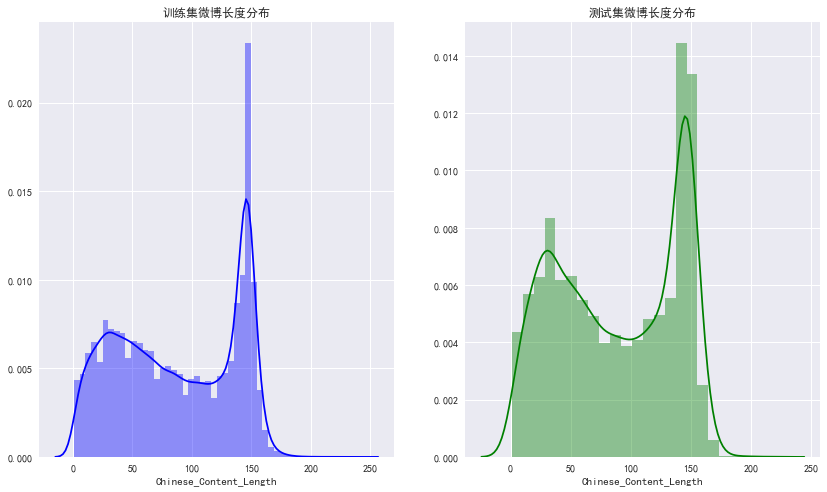

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.distplot(train_labeled_copy['Chinese_Content_Length'], ax=ax1, color='blue')
sns.distplot(test_copy['Chinese_Content_Length'], ax=ax2, color='green')

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集微博长度分布')
ax2.set_title('测试集微博长度分布')

plt.show()

看出点什么东西没？

### 正文词云

采用 `jieba` 和 `wordcloud` 对正文做一个词云。

In [16]:
stop = open('stopwords.txt', 'r+', encoding='utf-8')
stopword = stop.read().split("\n")
stopeword = set(stopword)
stop.close()

In [17]:
def stripword(seg):
    """停用词处理"""
    wordlist = []
    
    for key in seg.split(' '):
        #去除停用词和单字
        if not (key.strip() in stopword) and (len(key.strip()) > 1):
            wordlist.append(key)
    return ' '.join(wordlist)

def cutword(content):
    """分词，去除停用词，写得比较简陋"""
    seg_list = jieba.cut(content)
    line = " ".join(seg_list)
    word = stripword(line)
    return word

In [ ]:
train_labeled_copy['Chinese_Content_cut'] = train_labeled['Chinese_Content'].astype(str).apply(cutword)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\杨岱川\AppData\Local\Temp\jieba.cache
Loading model cost 0.669 seconds.
Prefix dict has been built successfully.


In [ ]:
train_labeled_copy.head(3)

In [ ]:
font = r'C:\\Windows\\fonts\\msyh.ttc' 
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(train_labeled_copy['Chinese_Content_cut'].values))

In [ ]:
plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 图片统计
在训练数据（微博）中，有些是有图片的，有些是没有图片的。

我们做一个简单统计：

In [ ]:
train_labeled_copy['Pic_Length'] = train_labeled_copy['Pictures'].apply(lambda x: len(eval(x)))
test_copy['Pic_Length'] = test_copy['Pictures'].apply(lambda x: len(eval(x)))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
ax1.set_xlim(0, 9)
ax2.set_xlim(0, 9)

sns.distplot(train_labeled_copy['Pic_Length'], bins=25, ax=ax1, color='blue', kde=False)
sns.distplot(test_copy['Pic_Length'], bins=25, ax=ax2, color='green', kde=False)

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集图片数量分布')
ax2.set_title('测试集图片数量分布')

plt.show()

可以看出分布非常近似，这里基本没什么问题。

大多数人都是不发图片或者发一张图片。

至于9图比7、8图的多，6图比5图多，大概是强迫症...

### 视频统计

视频计数在训练集和测试集中分布：

In [ ]:
train_labeled_copy['With_Video'] = train_labeled_copy['Videos'].apply(lambda x: len(eval(x)))
test_copy['With_Video'] = test_copy['Videos'].apply(lambda x: len(eval(x)))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

sns.countplot(train_labeled_copy['With_Video'], ax=ax1, color='grey')
sns.countplot(test_copy['With_Video'], ax=ax2, color='orange')

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集视频分布')
ax2.set_title('测试集视频分布')

plt.show()

看起来分布是一致的。

接下来我们看看带视频和不带视频的情感标签分布。

In [ ]:
train_labeled_copy_2 = train_labeled_copy[(train_labeled_copy["Labels"] == '0') |
                                          (train_labeled_copy["Labels"] == '1') |
                                          (train_labeled_copy["Labels"] == '-1')]

sns.countplot(x='With_Video', hue='Labels', data= train_labeled_copy_2,
              order = train_labeled_copy['With_Video'].dropna().value_counts().index)
plt.show()

可以看出，大部分带视频的微博，其情感为中性。

但是明显的，相对于不带视频的微博，带视频的微博中 `正面情感` 比例比 `负面情感` 的比例更高。

### 结语

后续看空闲再更新吧...希望这份简单的EDA对大家有所帮助。